In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, product
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
def ising_E(s, h, J, K, T=1):
    '''
    Returns the energy of a configuration s Ising model with up to 3-point interactions.
    s: state of Ising system (numpy array of length n)
    h: 1-point interactions/external field (numpy array of length n)
    J: 2-point interactions (numpy array of length nxn)
    K: 3-point interactions (numpy array of length nxnxn)
    T: temperature (float)
    '''
    E = -np.dot(s, h) - np.dot(s, np.dot(J, s)) - np.dot(s, np.dot(s, np.dot(K, s)))
    return E/T

def ising_BW(s, h, J, K, T=1, transform=True):
    '''
    Returns the Boltzmann weight of a configuration s Ising model with up to 3-point interactions.
    s: state of Ising system (numpy array of length n)
    h: 1-point interactions/external field (numpy array of length n)
    J: 2-point interactions (numpy array of length nxn)
    K: 3-point interactions (numpy array of length nxnxn)
    T: temperature (float)
    transform: Boolean to decide if the {0,1} basis should be transformed into the {-1, 1} basis
    '''
    s_transformed = np.array([2*s[i]-1 for i in range(len(s))])
    if transform:
        return np.exp(-ising_E(s_transformed, h, J, K, T))
    else:
        return np.exp(-ising_E(s, h, J, K, T))

def ising_P(s, h, J, K, T=1, transform=True):
    '''
    Returns the probablity of a configuration s Ising model with up to 3-point interactions.
    s: state of Ising system (numpy array of length n)
    h: 1-point interactions/external field (numpy array of length n)
    J: 2-point interactions (numpy array of length nxn)
    K: 3-point interactions (numpy array of length nxnxn)
    T: temperature (float)
    transform: Boolean to decide if the {0,1} basis should be transformed into the {-1, 1} basis
    '''
    Z = 0
    for t in product([0, 1], repeat=len(s)):
        Z += ising_BW(t, h, J, K, T, transform=transform)
    return ising_BW(s, h, J, K, T, transform=transform)/Z

In [3]:
def klDiv(p, q):
    '''
    Calculate the KL-divergence of two distributions
    p, q: arrays of probabilites or identically ordered dicts that map states into probabilities
    '''
    if type(p) == dict:
        p = np.array(list(p.values()))
    if type(q) == dict:
        q = np.array(list(q.values()))
        
    return np.sum(p * np.log(p/q))

In [4]:
def marginalize(p, margVar):
    '''
    Returns the distributions p, marginalised over the indices margVar
    p: a dict that maps states into probabilities
    margVar: a list of indices
    '''
    margVar = sorted(margVar)
    p_marg = {}
    for s, prob in p.items():
        s_marg = ''.join([s[i] for i in range(len(s)) if i in margVar])
        if s_marg in p_marg:
            p_marg[s_marg] += prob
        else:
            p_marg[s_marg] = prob
    return np.array([p_marg[s] for s in sorted(p_marg.keys())])

In [5]:
def difKL(p, q, coupVars=[0, 1]):
    '''
    These are the higher-order disentangled 'Delta' contributions to the KL-divergence
    p, q: identically ordered dicts that map states into probabilities
    coupVars: list of indices, the variables for which to calculate the Delta's
    '''
    runSum = 0

    for r in range(1, len(coupVars)+1):
        toMarg = list(combinations(coupVars, r=r))
        for margVar in toMarg:
            runSum += (-1)**(r - len(coupVars)) * klDiv(marginalize(p, margVar), marginalize(q, margVar))

    return runSum

# Disentangling the KL-divergence with respect to the uniform distribution

In [6]:
# Number of spins in Ising model
N = 4
states = np.array(list(product([0, 1], repeat=N)))

# Range of coupling perturbations to study
n=21
scaleRange = np.linspace(-1, 1, n)

# The uniform distribution:
freeThy = {''.join(s.astype(str)): ising_P(s, np.zeros(N), np.zeros((N, N)), np.zeros((N, N, N)), 1, transform=True) for s in states}

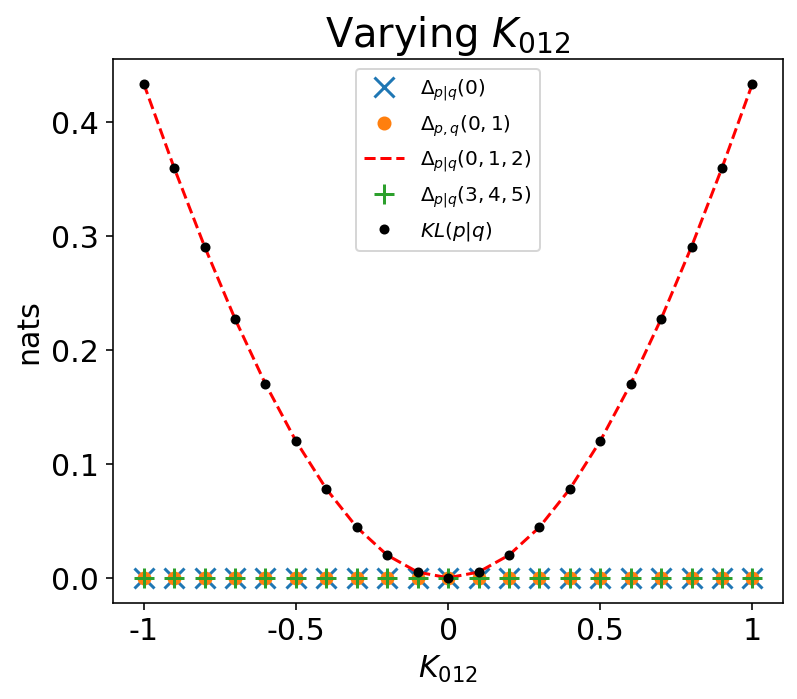

In [7]:
intThys = []

K = np.zeros((N, N, N))

for scale in scaleRange:
    # Divide by 6 to account for index permutation symmetry
    kNew = (K).copy()
    kNew[0, 1, 2] = scale/6
    kNew[0, 2, 1] = scale/6
    kNew[1, 0, 2] = scale/6
    kNew[1, 2, 0] = scale/6
    kNew[2, 0, 1] = scale/6
    kNew[2, 1, 0] = scale/6
    intThys.append({''.join(s.astype(str)): ising_P(s, np.zeros(N), np.zeros((N, N)), kNew, 1, transform=True) for s in states})

plt.figure(figsize=(6, 5))
plt.plot([difKL(freeThy, intThy, [0]) for intThy in intThys], 'x', markersize=10, mew=1.5, label=r'$\Delta_{p|q}(0)$')
plt.plot([difKL(freeThy, intThy, [0, 1]) for intThy in intThys], 'o', label=r'$\Delta_{p, q}(0, 1)$')
plt.plot([difKL(freeThy, intThy, [0, 1, 2]) for intThy in intThys], 'r--', markersize=10, mew=1.5, label=r'$\Delta_{p|q}(0, 1, 2)$')
plt.plot([difKL(freeThy, intThy, [3, 4, 5]) for intThy in intThys], '+', markersize=10, mew=1.5, label=r'$\Delta_{p|q}(3, 4, 5)$')
plt.plot([klDiv(freeThy, intThy) for intThy in intThys], 'ko', markersize=4, label=r'$KL(p|q)$' )

plt.xticks(np.arange(0, n, 5), [-1, -0.5, 0, 0.5, 1], fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$K_{012}$', fontsize=15)
plt.ylabel('nats', fontsize=15)
plt.title('Varying $K_{012}$', fontsize=20)
plt.legend()
plt.savefig('compHOS_arxiv/figs/klDecomp_K.pdf')
plt.show()

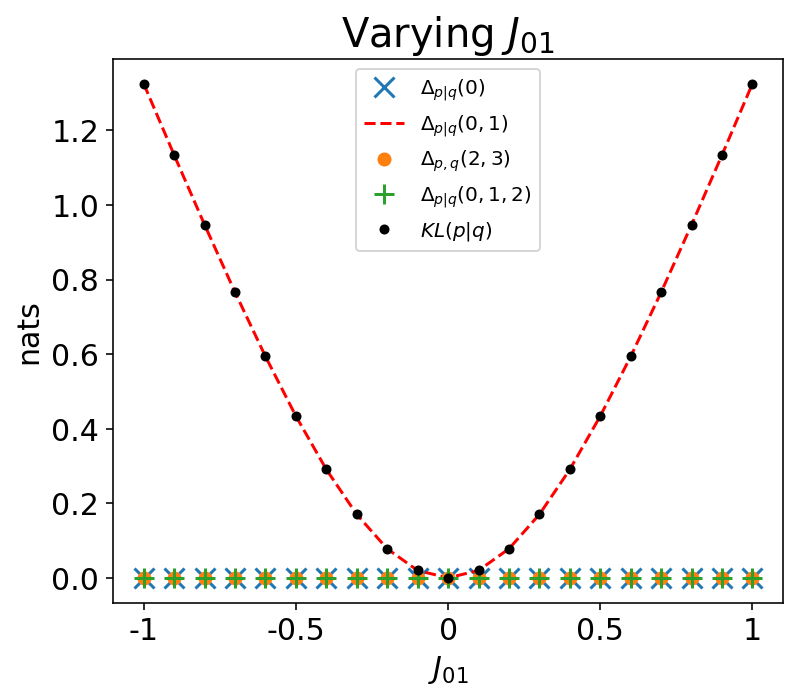

In [8]:
intThys = []

J = np.zeros((N, N))
for scale in scaleRange:
    jNew = (J*0).copy()
    jNew[0, 1] = scale
    jNew[1, 0] = scale

    intThys.append({''.join(s.astype(str)): ising_P(s, np.zeros(N), jNew, np.zeros((N, N, N)), 1, transform=True) for s in states})

plt.figure(figsize=(6, 5))
plt.plot([difKL(freeThy, intThy, [0]) for intThy in intThys], 'x', markersize=10, mew=1.5,label=r'$\Delta_{p|q}(0)$')
plt.plot([difKL(freeThy, intThy, [0, 1]) for intThy in intThys], 'r--', markersize=10, mew=1.5,label=r'$\Delta_{p|q}(0, 1)$')
plt.plot([difKL(freeThy, intThy, [2, 3]) for intThy in intThys], 'o', label=r'$\Delta_{p, q}(2, 3)$')
plt.plot([difKL(freeThy, intThy, [0, 1, 2]) for intThy in intThys], '+', markersize=10, mew=1.5,label=r'$\Delta_{p|q}(0, 1, 2)$')
plt.plot([klDiv(freeThy, intThy) for intThy in intThys], 'ko', markersize=4, label=r'$KL(p | q)$' )

plt.xticks(np.arange(0, n, 5), [-1, -0.5, 0, 0.5, 1], fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$J_{01}$', fontsize=15)
plt.ylabel('nats', fontsize=15)
plt.title('Varying $J_{01}$', fontsize=20)
plt.legend()
plt.savefig('compHOS_arxiv/figs/klDecomp_J.pdf')
plt.show()

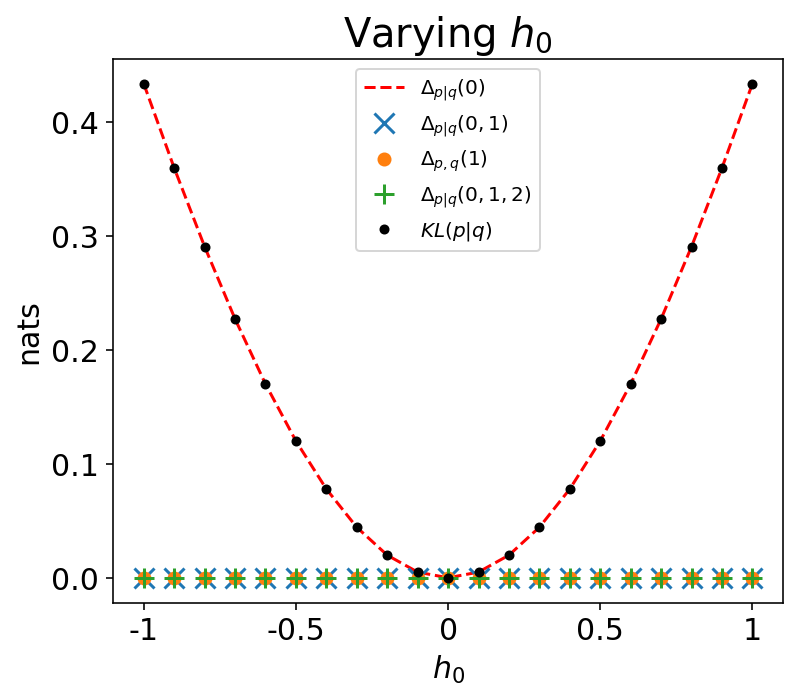

In [9]:
intThys = []

h = np.zeros(N)
for scale in scaleRange:
    hNew = (h*0).copy()
    hNew[0] = scale
    intThys.append({''.join(s.astype(str)): ising_P(s, hNew, np.zeros((N, N)), np.zeros((N, N, N)), 1, transform=True) for s in states})

plt.figure(figsize=(6, 5))
plt.plot([difKL(freeThy, intThy, [0]) for intThy in intThys], 'r--', markersize=10, mew=1.5,label=r'$\Delta_{p|q}(0)$')
plt.plot([difKL(freeThy, intThy, [0, 1]) for intThy in intThys], 'x', markersize=10, mew=1.5,label=r'$\Delta_{p|q}(0, 1)$')
plt.plot([difKL(freeThy, intThy, [1]) for intThy in intThys], 'o', label=r'$\Delta_{p, q}(1)$')
plt.plot([difKL(freeThy, intThy, [0, 1, 2]) for intThy in intThys], '+', markersize=10, mew=1.5,label=r'$\Delta_{p|q}(0, 1, 2)$')
plt.plot([klDiv(freeThy, intThy) for intThy in intThys], 'ko', markersize=4, label=r'$KL(p | q)$' )

plt.xticks(np.arange(0, n, 5), [-1, -0.5, 0, 0.5, 1], fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$h_{0}$', fontsize=15)
plt.ylabel('nats', fontsize=15)
plt.title('Varying $h_{0}$', fontsize=20)
plt.legend()
plt.savefig('compHOS_arxiv/figs/klDecomp_h.pdf')
plt.show()

# Disentangling the KL-divergence with respect to interacting theories

In [10]:
# To overcome the noise of the randomised interactions, we explore a larger range of couplings
scaleRange = np.linspace(-1, 1, n)*10

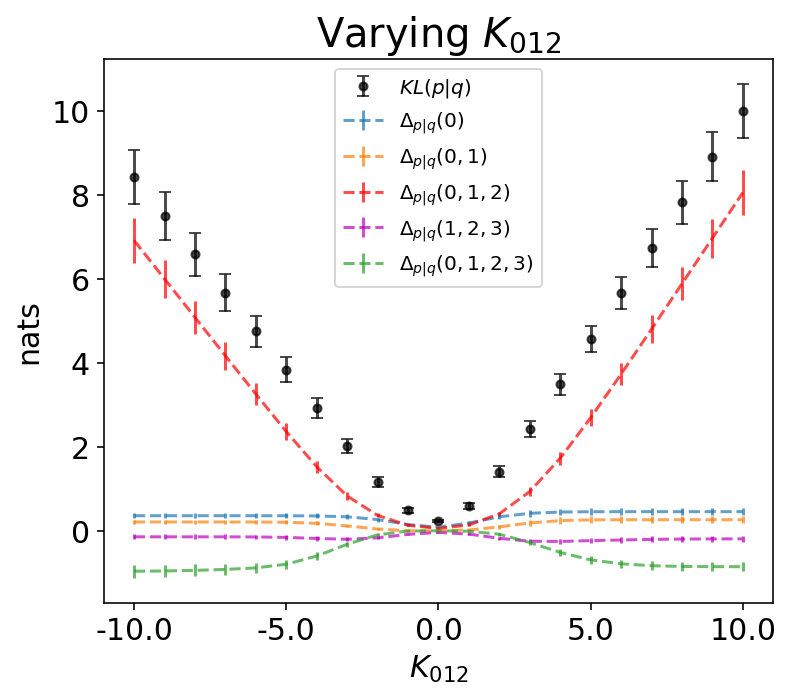

In [11]:
N=4
states = np.array(list(product([0, 1], repeat=N)))

resDict = {'kl': [], 'd0': [], 'd01': [], 'd0123':[], 'd012': [], 'd123': []}
nSamps = 100

for _ in range(nSamps):
    h = np.random.randn(N)
    
    J = np.zeros((N, N))
    for i, j in combinations(range(N), 2):
        if abs(j-i)==1 or abs(j-1) == N-1:
            c = np.random.randn()
            J[i, j] = c
            J[j, i] = c
    J = J/2

    K = np.zeros((N, N, N))
    for i, j, k in combinations(range(N), 3):
        if (i!=j and j!=k and i!=k):
            c = np.random.randn()
            K[i, j, k] = c
            K[i, k, j] = c
            K[j, i, k] = c
            K[j, k, i] = c
            K[k, i, j] = c
            K[k, j, i] = c

    K = K/6


    refThy = {''.join(s.astype(str)): ising_P(s, h, J, K, 1, transform=True) for s in states}
    intThys = []

    for scale in scaleRange:
        kNew = K.copy()
        kNew[0, 1, 2] = scale/6
        kNew[0, 2, 1] = scale/6
        kNew[1, 0, 2] = scale/6
        kNew[1, 2, 0] = scale/6
        kNew[2, 0, 1] = scale/6
        kNew[2, 1, 0] = scale/6
        intThys.append({''.join(s.astype(str)): ising_P(s, h, J, kNew, 1, transform=True) for s in states})

    resDict['kl'].append([klDiv(refThy, intThy) for intThy in intThys])
    resDict['d0'].append([difKL(refThy, intThy, [0]) for intThy in intThys])
    resDict['d01'].append([difKL(refThy, intThy, [0, 1]) for intThy in intThys])
    resDict['d0123'].append([difKL(refThy, intThy, [0, 1, 2, 3]) for intThy in intThys])
    resDict['d012'].append([difKL(refThy, intThy, [0, 1, 2]) for intThy in intThys])
    resDict['d123'].append([difKL(refThy, intThy, [1, 2, 3]) for intThy in intThys])


plt.figure(figsize=(6, 5))
plt.errorbar(x = np.arange(len(scaleRange)), y=np.array(resDict['kl']).mean(axis=0), yerr=np.array(resDict['kl']).std(axis=0)/np.sqrt(nSamps), capsize=3, fmt='ko', markersize=4, label=r'$KL(p | q)$' , alpha=0.7)
plt.errorbar(x = np.arange(len(scaleRange)), y=np.array(resDict['d0']).mean(axis=0), yerr=np.array(resDict['d0']).std(axis=0)/np.sqrt(nSamps), fmt='--', markersize=10, label=r'$\Delta_{p | q}(0)$' , alpha=0.7)
plt.errorbar(x = np.arange(len(scaleRange)), y=np.array(resDict['d01']).mean(axis=0), yerr=np.array(resDict['d01']).std(axis=0)/np.sqrt(nSamps), fmt='--', markersize=4, label=r'$\Delta_{p | q}(0, 1)$' , alpha=0.7)
plt.errorbar(x = np.arange(len(scaleRange)), y=np.array(resDict['d012']).mean(axis=0), yerr=np.array(resDict['d012']).std(axis=0)/np.sqrt(nSamps), fmt='r--', markersize=10, label=r'$\Delta_{p | q}(0, 1, 2)$' , alpha=0.7)
plt.errorbar(x = np.arange(len(scaleRange)), y=np.array(resDict['d123']).mean(axis=0), yerr=np.array(resDict['d123']).std(axis=0)/np.sqrt(nSamps), fmt='m--', markersize=10, label=r'$\Delta_{p | q}(1, 2, 3)$' , alpha=0.7)
plt.errorbar(x = np.arange(len(scaleRange)), y=np.array(resDict['d0123']).mean(axis=0), yerr=np.array(resDict['d0123']).std(axis=0)/np.sqrt(nSamps), fmt='--', markersize=10, label=r'$\Delta_{p | q}(0, 1, 2, 3)$' , alpha=0.7)

plt.xticks(np.arange(0, n, 5), scaleRange[np.arange(0, n, 5)], fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$K_{012}$', fontsize=15)
plt.ylabel('nats', fontsize=15)
plt.title('Varying $K_{012}$', fontsize=20)
plt.legend()
plt.savefig('compHOS_arxiv/figs/klDecomp_K_int.pdf')
plt.show()


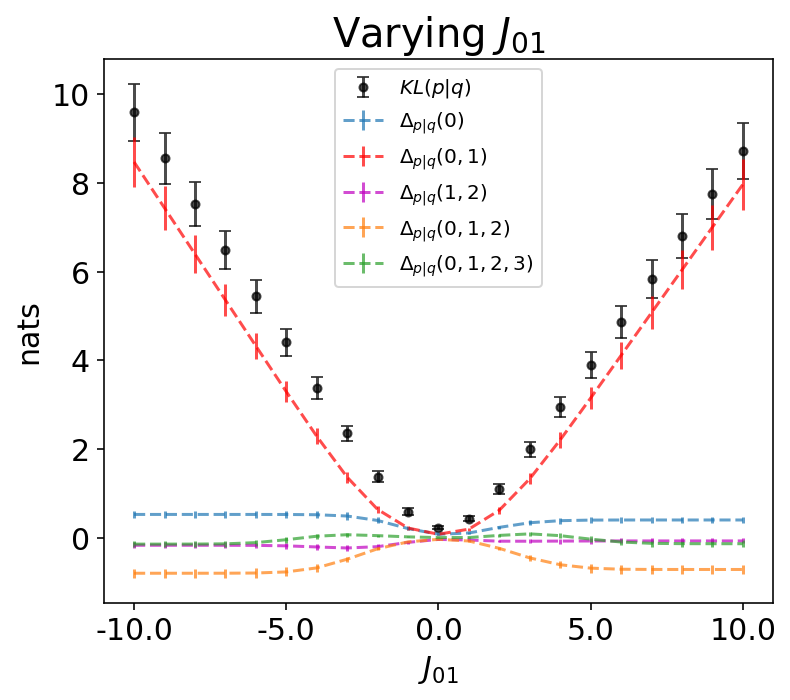

In [12]:
N=4

states = np.array(list(product([0, 1], repeat=N)))

resDict = {'kl': [], 'd0': [], 'd01': [], 'd12': [], 'd0123':[], 'd012': []}

nSamps = 100

for _ in range(nSamps):
    h = np.random.randn(N)
    
    J = np.zeros((N, N))
    for i, j in combinations(range(N), 2):
        if abs(j-i)==1 or abs(j-1) == N-1:
            c = np.random.randn()
            J[i, j] = c
            J[j, i] = c
    J = J/2

    K = np.zeros((N, N, N))
    for i, j, k in combinations(range(N), 3):
        if (i!=j and j!=k and i!=k):
            c = np.random.randn()
            K[i, j, k] = c
            K[i, k, j] = c
            K[j, i, k] = c
            K[j, k, i] = c
            K[k, i, j] = c
            K[k, j, i] = c

    K = K/6


    refThy = {''.join(s.astype(str)): ising_P(s, h, J, K, 1, transform=True) for s in states}
    intThys = []

    for scale in scaleRange:
        jNew = (J).copy()
        jNew[0, 1] = scale/2
        jNew[1, 0] = scale/2

        intThys.append({''.join(s.astype(str)): ising_P(s, h, jNew, K, 1, transform=True) for s in states})
        
    resDict['kl'].append([klDiv(refThy, intThy) for intThy in intThys])
    resDict['d0'].append([difKL(refThy, intThy, [0]) for intThy in intThys])
    resDict['d01'].append([difKL(refThy, intThy, [0, 1]) for intThy in intThys])
    resDict['d12'].append([difKL(refThy, intThy, [1, 2]) for intThy in intThys])
    resDict['d0123'].append([difKL(refThy, intThy, [0, 1, 2, 3]) for intThy in intThys])
    resDict['d012'].append([difKL(refThy, intThy, [0, 1, 2]) for intThy in intThys])



plt.figure(figsize=(6, 5))
plt.errorbar(x = np.arange(len(scaleRange)), y=np.array(resDict['kl']).mean(axis=0), yerr=np.array(resDict['kl']).std(axis=0)/np.sqrt(nSamps), capsize=3, fmt='ko', markersize=4, label=r'$KL(p | q)$' , alpha=0.7)
plt.errorbar(x = np.arange(len(scaleRange)), y=np.array(resDict['d0']).mean(axis=0), yerr=np.array(resDict['d0']).std(axis=0)/np.sqrt(nSamps), fmt='--', markersize=10, label=r'$\Delta_{p | q}(0)$' , alpha=0.7)
plt.errorbar(x = np.arange(len(scaleRange)), y=np.array(resDict['d01']).mean(axis=0), yerr=np.array(resDict['d01']).std(axis=0)/np.sqrt(nSamps), fmt='r--', markersize=4, label=r'$\Delta_{p | q}(0, 1)$' , alpha=0.7)
plt.errorbar(x = np.arange(len(scaleRange)), y=np.array(resDict['d12']).mean(axis=0), yerr=np.array(resDict['d12']).std(axis=0)/np.sqrt(nSamps), fmt='m--', markersize=4, label=r'$\Delta_{p | q}(1, 2)$' , alpha=0.7)
plt.errorbar(x = np.arange(len(scaleRange)), y=np.array(resDict['d012']).mean(axis=0), yerr=np.array(resDict['d012']).std(axis=0)/np.sqrt(nSamps), fmt='--', markersize=10, label=r'$\Delta_{p | q}(0, 1, 2)$' , alpha=0.7)
plt.errorbar(x = np.arange(len(scaleRange)), y=np.array(resDict['d0123']).mean(axis=0), yerr=np.array(resDict['d0123']).std(axis=0)/np.sqrt(nSamps), fmt='--', markersize=10, label=r'$\Delta_{p | q}(0, 1, 2, 3)$' , alpha=0.7)

plt.xticks(np.arange(0, n, 5), scaleRange[np.arange(0, n, 5)], fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$J_{01}$', fontsize=15)
plt.ylabel('nats', fontsize=15)
plt.title('Varying $J_{01}$', fontsize=20)
plt.legend()
plt.savefig('compHOS_arxiv/figs/klDecomp_J_int.pdf')
plt.show()


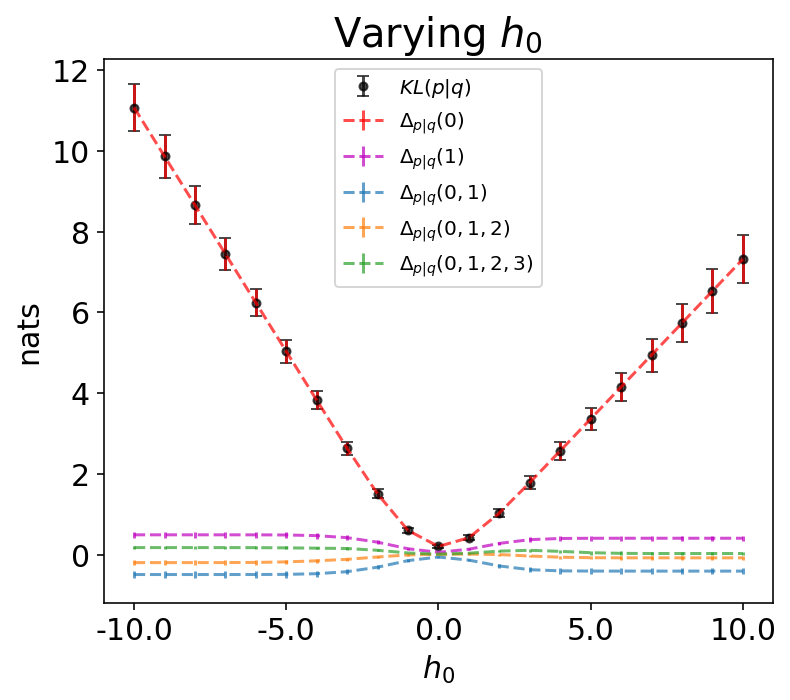

In [13]:
N=4

states = np.array(list(product([0, 1], repeat=N)))

resDict = {'kl': [], 'd0': [], 'd1': [], 'd01': [], 'd0123':[], 'd012': []}

nSamps = 100

for _ in range(nSamps):
    h = np.random.randn(N)
    
    J = np.zeros((N, N))
    for i, j in combinations(range(N), 2):
        if abs(j-i)==1 or abs(j-1) == N-1:
            c = np.random.randn()
            J[i, j] = c
            J[j, i] = c
    J = J/2

    K = np.zeros((N, N, N))
    for i, j, k in combinations(range(N), 3):
        if (i!=j and j!=k and i!=k):
            c = np.random.randn()
            K[i, j, k] = c
            K[i, k, j] = c
            K[j, i, k] = c
            K[j, k, i] = c
            K[k, i, j] = c
            K[k, j, i] = c

    K = K/6


    refThy = {''.join(s.astype(str)): ising_P(s, h, J, K, 1, transform=True) for s in states}
    intThys = []

    for scale in scaleRange:
        hNew = (h).copy()
        hNew[0] = scale
        intThys.append({''.join(s.astype(str)): ising_P(s, hNew, J, K, 1, transform=True) for s in states})
        
    resDict['kl'].append([klDiv(refThy, intThy) for intThy in intThys])
    resDict['d0'].append([difKL(refThy, intThy, [0]) for intThy in intThys])
    resDict['d1'].append([difKL(refThy, intThy, [1]) for intThy in intThys])
    resDict['d01'].append([difKL(refThy, intThy, [0, 1]) for intThy in intThys])
    resDict['d0123'].append([difKL(refThy, intThy, [0, 1, 2, 3]) for intThy in intThys])
    resDict['d012'].append([difKL(refThy, intThy, [0, 1, 2]) for intThy in intThys])



plt.figure(figsize=(6, 5))
plt.errorbar(x = np.arange(len(scaleRange)), y=np.array(resDict['kl']).mean(axis=0), yerr=np.array(resDict['kl']).std(axis=0)/np.sqrt(nSamps), capsize=3, fmt='ko', markersize=4, label=r'$KL(p | q)$' , alpha=0.7)
plt.errorbar(x = np.arange(len(scaleRange)), y=np.array(resDict['d0']).mean(axis=0), yerr=np.array(resDict['d0']).std(axis=0)/np.sqrt(nSamps), fmt='r--', markersize=10, label=r'$\Delta_{p | q}(0)$' , alpha=0.7)
plt.errorbar(x = np.arange(len(scaleRange)), y=np.array(resDict['d1']).mean(axis=0), yerr=np.array(resDict['d1']).std(axis=0)/np.sqrt(nSamps), fmt='m--', markersize=10, label=r'$\Delta_{p | q}(1)$' , alpha=0.7)
plt.errorbar(x = np.arange(len(scaleRange)), y=np.array(resDict['d01']).mean(axis=0), yerr=np.array(resDict['d01']).std(axis=0)/np.sqrt(nSamps), fmt='--', markersize=4, label=r'$\Delta_{p | q}(0, 1)$' , alpha=0.7)
plt.errorbar(x = np.arange(len(scaleRange)), y=np.array(resDict['d012']).mean(axis=0), yerr=np.array(resDict['d012']).std(axis=0)/np.sqrt(nSamps), fmt='--', markersize=10, label=r'$\Delta_{p | q}(0, 1, 2)$' , alpha=0.7)
plt.errorbar(x = np.arange(len(scaleRange)), y=np.array(resDict['d0123']).mean(axis=0), yerr=np.array(resDict['d0123']).std(axis=0)/np.sqrt(nSamps), fmt='--', markersize=10, label=r'$\Delta_{p | q}(0, 1, 2, 3)$' , alpha=0.7)

plt.xticks(np.arange(0, n, 5), scaleRange[np.arange(0, n, 5)], fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$h_{0}$', fontsize=15)
plt.ylabel('nats', fontsize=15)
plt.title('Varying $h_{0}$', fontsize=20)
plt.legend()
plt.savefig('compHOS_arxiv/figs/klDecomp_h_int.pdf')
plt.show()
